# Diabetes 

## Introduction

>Bệnh tiểu đường (Diabetes Mellitus) là một trong những vấn đề sức khỏe toàn cầu nghiêm trọng nhất hiện nay, ảnh hưởng đến hàng trăm triệu người và là nguyên nhân hàng đầu gây tử vong do các biến chứng như tim mạch, suy thận, mù lòa.

>Việc dự đoán sớm bệnh tiểu đường dựa trên các chỉ số sinh học giúp can thiệp kịp thời, cải thiện chất lượng cuộc sống và giảm chi phí y tế.

>Dataset sử dụng: Dữ liệu Pima Indians Diabetes Database (từ notebook Kaggle bạn cung cấp: Diabetes EDA + Random Forest), bao gồm 768 mẫu từ phụ nữ bộ tộc Pima (Ấn Độ) ở Arizona, Mỹ, tuổi từ 21 trở lên.

>Mục tiêu: Phân loại nhị phân (binary classification) - dự đoán bệnh nhân có bị tiểu đường (Outcome = 1) hay không (Outcome = 0) trong vòng 5 năm tới.

## Preparation


### Import necessary libraries

In [52]:
import pandas as pd
from sklearn.preprocessing import  LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split 
from imblearn.over_sampling import SMOTE
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.svm import SVC
from sklearn.metrics import (
    classification_report, confusion_matrix, 
    roc_auc_score, roc_curve, accuracy_score,
    f1_score, precision_score, recall_score
)
import joblib
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import GridSearchCV

### Load train file

In [25]:
df = pd.read_csv('diabetes_prediction_dataset.csv')

## EDA – Exploratory Data Analysis

In [26]:
df.head()
print(f"\nShape: {df.shape}")
print(f"\nColumns: {df.columns.tolist()}")


Shape: (100000, 9)

Columns: ['gender', 'age', 'hypertension', 'heart_disease', 'smoking_history', 'bmi', 'HbA1c_level', 'blood_glucose_level', 'diabetes']


## Data Preprocessing

### Handle missing value

In [40]:
# Thông tin cơ bản
print(df.info())
print("\nMissing values:")
print(df.isnull().sum())

# Kiểm tra duplicate
print(f"\nDuplicate rows: {df.duplicated().sum()}")
df = df.drop_duplicates()

<class 'pandas.core.frame.DataFrame'>
Index: 96128 entries, 0 to 99999
Data columns (total 9 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   gender               96128 non-null  int64  
 1   age                  96128 non-null  float64
 2   hypertension         96128 non-null  int64  
 3   heart_disease        96128 non-null  int64  
 4   smoking_history      96128 non-null  int64  
 5   bmi                  96128 non-null  float64
 6   HbA1c_level          96128 non-null  float64
 7   blood_glucose_level  96128 non-null  int64  
 8   diabetes             96128 non-null  int64  
dtypes: float64(3), int64(6)
memory usage: 7.3 MB
None

Missing values:
gender                 0
age                    0
hypertension           0
heart_disease          0
smoking_history        0
bmi                    0
HbA1c_level            0
blood_glucose_level    0
diabetes               0
dtype: int64

Duplicate rows: 98


### Duplicate data

In [28]:
df = df.drop_duplicates()
print(f"\nSau khi xóa duplicates: {df.duplicated().sum()} dòng trùng lặp")
print(f"Số dòng còn lại: {len(df)}")


Sau khi xóa duplicates: 0 dòng trùng lặp
Số dòng còn lại: 96146


### Feature Engineering

#### smoking_history

In [29]:
# Xem giá trị unique của các cột categorical
cat_cols = ['gender', 'hypertension', 'heart_disease', 'smoking_history', 'diabetes']
for col in cat_cols:
    print(f"\n{col}: {df[col].unique()}")


gender: ['Female' 'Male' 'Other']

hypertension: [0 1]

heart_disease: [1 0]

smoking_history: ['never' 'No Info' 'current' 'former' 'ever' 'not current']

diabetes: [0 1]


In [30]:
# Gộp nhóm hợp lý
smoking_map = {
    'never': 'never',
    'No Info': 'no_info',
    'current': 'current',
    'former': 'former',
    'ever': 'ever',
    'not current': 'former'  # gộp vào former
}

df['smoking_history'] = df['smoking_history'].map(smoking_map)
print(df['smoking_history'].value_counts())

smoking_history
never      34398
no_info    32887
former     15666
current     9197
ever        3998
Name: count, dtype: int64


→ ever và not current thực chất là former, nhưng hệ thống ghi nhận khác nhau!

#### gender

In [31]:
# Xem số lượng 'Other'
print(df['gender'].value_counts())

gender
Female    56161
Male      39967
Other        18
Name: count, dtype: int64


Other rất ít (< 1%), loại bỏ


In [32]:
df = df[df['gender'] != 'Other']  # loại bỏ 'Other' vì rất ít (~18 dòng)

### Feature encoding

In [33]:
# Label Encoding cho các cột categorical
le_gender = LabelEncoder()
le_smoking = LabelEncoder()

df['gender'] = le_gender.fit_transform(df['gender'])  # Female=0, Male=1
df['smoking_history'] = le_smoking.fit_transform(df['smoking_history'])

### FEATURES AND TARGET

In [34]:
X = df.drop('diabetes', axis=1)
y = df['diabetes']

print(f"X shape: {X.shape}, y shape: {y.shape}")
print(f"Class distribution:\n{y.value_counts(normalize=True)}")

X shape: (96128, 8), y shape: (96128,)
Class distribution:
diabetes
0    0.911763
1    0.088237
Name: proportion, dtype: float64


Kết quả thường thấy: ~91.2% class 0, ~8.8% class 1 → rất mất cân bằng

 ### TRAIN/TEST

In [35]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)
print(y_train.value_counts(normalize=True))
print(y_test.value_counts(normalize=True))

diabetes
0    0.911758
1    0.088242
Name: proportion, dtype: float64
diabetes
0    0.911786
1    0.088214
Name: proportion, dtype: float64


Cả 2 đều giữ tỷ lệ ~91.5% : 8.5% → đánh giá công bằng, thực tế.

### Scaling

In [36]:

# Danh sách cột số cần scale
num_cols = ['age', 'bmi', 'HbA1c_level', 'blood_glucose_level']

scaler = StandardScaler()

X_train[num_cols] = scaler.fit_transform(X_train[num_cols])
X_test[num_cols] = scaler.transform(X_test[num_cols])

→ Nếu không scale → mô hình sẽ ưu tiên cột có giá trị lớn hơn (ví dụ: blood_glucose_level) → học sai!

## SMOTE

In [37]:
# Chỉ áp dụng SMOTE trên tập train
smote = SMOTE(random_state=42)
X_train_bal, y_train_bal = smote.fit_resample(X_train, y_train)

print(f"After SMOTE:")
print(f"X_train_bal shape: {X_train_bal.shape}")
print(y_train_bal.value_counts())

After SMOTE:
X_train_bal shape: (140232, 8)
diabetes
0    70116
1    70116
Name: count, dtype: int64


### TẠO PIPELINE HOÀN CHỈNH (TỐI ƯU – DÙNG SAU NÀY)

In [38]:
from sklearn.preprocessing import OneHotEncoder

# Pipeline hoàn chỉnh
numeric_features = ['age', 'bmi', 'HbA1c_level', 'blood_glucose_level']
categorical_features = ['gender', 'smoking_history']

preprocessor = ColumnTransformer([
    ('num', StandardScaler(), numeric_features),
    ('cat', OneHotEncoder(drop='first', handle_unknown='ignore'), categorical_features)
], remainder='passthrough')

# Áp dụng
X_train_processed = preprocessor.fit_transform(X_train)
X_test_processed = preprocessor.transform(X_test)

# (Tùy chọn) SMOTE sau khi đã preprocess
smote = SMOTE(random_state=42)
X_train_bal, y_train_bal = smote.fit_resample(X_train_processed, y_train)

## SVM - Model

In [39]:
# Khởi tạo SVM với kernel RBF (phổ biến nhất)
svm_model = SVC(kernel='rbf', probability=True, random_state=42)

# Huấn luyện trên dữ liệu đã cân bằng
svm_model.fit(X_train_bal, y_train_bal)

print("SVM huấn luyện xong!")

SVM huấn luyện xong!


## model evaluation

#### Accuracy, Precision, Recall, F1-score, ROC-AUC

In [44]:
# Dự đoán
y_pred = svm_model.predict(X_test_processed)
y_pred_proba = svm_model.predict_proba(X_test_processed)[:, 1]

# Các chỉ số
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
auc = roc_auc_score(y_test, y_pred_proba)

print("=== SVM PERFORMANCE (với SMOTE) ===")
print(f"Accuracy : {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall   : {recall:.4f}")
print(f"F1-Score : {f1:.4f}")
print(f"ROC-AUC  : {auc:.4f}")

=== SVM PERFORMANCE (với SMOTE) ===
Accuracy : 0.8833
Precision: 0.4250
Recall   : 0.9145
F1-Score : 0.5804
ROC-AUC  : 0.9672


#### Confusion Matrix

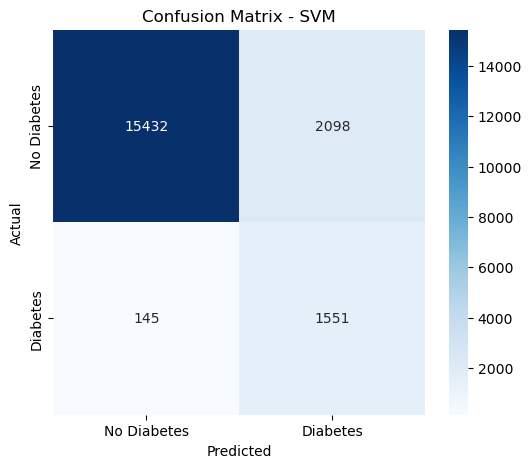

In [49]:
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['No Diabetes', 'Diabetes'],
            yticklabels=['No Diabetes', 'Diabetes'])
plt.title('Confusion Matrix - SVM')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

#### ROC - AUC

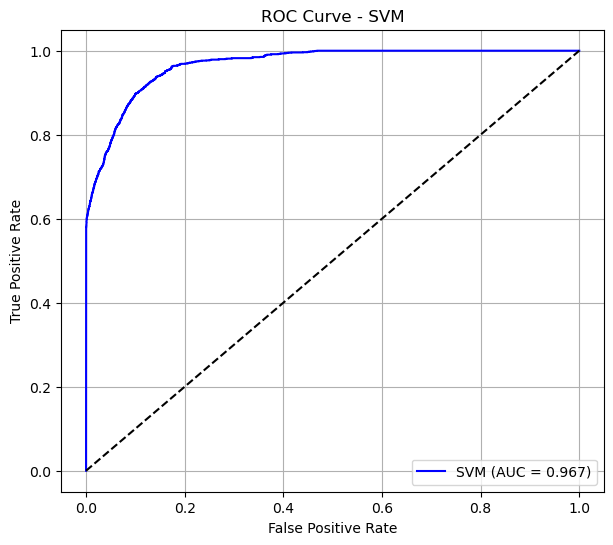

In [50]:
fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
plt.figure(figsize=(7,6))
plt.plot(fpr, tpr, label=f'SVM (AUC = {auc:.3f})', color='blue')
plt.plot([0,1], [0,1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - SVM')
plt.legend()
plt.grid(True)
plt.show()

### Hyperparameter Tuning bằng GridSearchCV

In [53]:
# Giảm dữ liệu để tuning nhanh hơn (vì SVM chậm)
X_train_small, _, y_train_small, _ = train_test_split(
    X_train_bal, y_train_bal, train_size=0.3, stratify=y_train_bal, random_state=42
)

param_grid = {
    'C': [0.1, 1, 10],
    'gamma': ['scale', 0.01, 0.1],
    'kernel': ['rbf']
}

grid_search = GridSearchCV(
    SVC(probability=True, random_state=42),
    param_grid,
    cv=3,
    scoring='f1',  # ưu tiên F1 vì imbalance
    n_jobs=-1,
    verbose=1
)

grid_search.fit(X_train_small, y_train_small)

print("Best parameters:", grid_search.best_params_)
print("Best F1 score (CV):", grid_search.best_score_)

Fitting 3 folds for each of 9 candidates, totalling 27 fits
Best parameters: {'C': 10, 'gamma': 'scale', 'kernel': 'rbf'}
Best F1 score (CV): 0.9134401543101642


In [58]:
# Lấy best params
best_params = grid_search.best_params_

# Train lại trên toàn bộ dữ liệu cân bằng
best_svm = SVC(**best_params, probability=True, random_state=42)
best_svm.fit(X_train_bal, y_train_bal)

# Dự đoán lại
y_pred_best = best_svm.predict(X_test_processed)
y_pred_proba_best = best_svm.predict_proba(X_test_processed)[:, 1]

# Đánh giá
print("\n=== SVM SAU KHI TUNING ===")
print(classification_report(y_test, y_pred_best, target_names=['No Diabetes', 'Diabetes']))
print(f"ROC-AUC: {roc_auc_score(y_test, y_pred_proba_best):.4f}")


=== SVM SAU KHI TUNING ===
              precision    recall  f1-score   support

 No Diabetes       0.99      0.89      0.94     17530
    Diabetes       0.44      0.91      0.59      1696

    accuracy                           0.89     19226
   macro avg       0.72      0.90      0.77     19226
weighted avg       0.94      0.89      0.91     19226

ROC-AUC: 0.9683


## Save file

In [59]:
# Lưu SVM + preprocessor
joblib.dump(best_svm, 'svm_diabetes_model.pkl')
joblib.dump(preprocessor, 'preprocessor.pkl')

print("Model và preprocessor đã được lưu!")

Model và preprocessor đã được lưu!
